In [2]:
import os
import torch

from lightning_modules import DeepImageHomographyEstimationModuleBackbone
from utils.io import load_yaml

# load best model\n",
prefix = '/home/martin/Tresors/homography_imitation_learning_logs/deep_image_homography_estimation_backbone/version_2'
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/unsupervised_deep_homography_estimation_backbone/version_0'
configs = load_yaml(os.path.join(prefix, 'configs.yml'))
model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(prefix, 'checkpoints/epoch=49.ckpt'), shape=configs['model']['shape'])

device = 'cpu'
if torch.cuda.is_available():
    print('Running with CUDA backend.')
    device = 'cuda'

model.to(device)
model = model.eval()

Running with CUDA backend.


In [3]:
# motion dataset
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from datasets import ImageSequenceDataset

prefix = '/media/martin/Samsung_T5/data/endoscopic_data/camera_motion_separated_png/with_camera_motion'
df_name = 'log_with_camera_motion_seq_len_2.pkl'
df = pd.read_pickle(os.path.join(prefix, df_name))
ds = ImageSequenceDataset(df, prefix, ToTensor())
dl = DataLoader(ds, batch_size=1)


Epoch 1999/2000h_target tensor([[[  6.5917,   0.3890],
         [  5.0608,  -4.5812],
         [-11.5985,  -3.3925],
         [ -2.8664,   2.0867]]], device='cuda:0')
h tensor([[[  6.5939,   0.3905],
         [  5.0595,  -4.5804],
         [-11.5981,  -3.3926],
         [ -2.8666,   2.0858]]], device='cuda:0', grad_fn=<ViewBackward>)


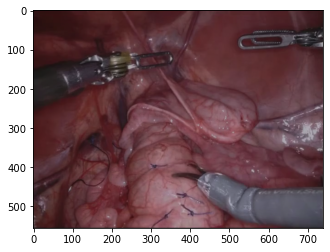

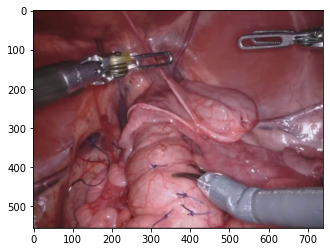

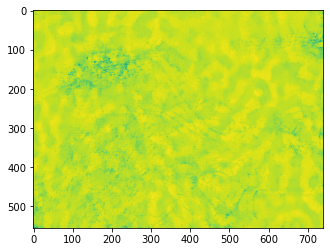

In [55]:
from torch.optim import Adam
from torch.nn.functional import mse_loss
from kornia import tensor_to_image, get_perspective_transform, warp_perspective
import matplotlib.pyplot as plt

from utils.processing import image_edges, four_pt_to_matrix_homography_representation

sample = next(iter(dl))
sample[0].shape

mask0 = torch.ones([1, 1, sample[0].shape[-2], sample[0].shape[-1]], device=device, requires_grad=True)
mask1 = torch.ones([1, 1, sample[0].shape[-2], sample[0].shape[-1]], device=device, requires_grad=True)
zeros = torch.zeros([1, 1, sample[0].shape[-2], sample[0].shape[-1]], device=device)

# optim = Adam([mask0, mask1], lr=1e-2)
optim = Adam([mask0], lr=1e-2)

# find attention mask
model = model.train()

batch = next(iter(dl))
img0 = batch[0].to(device)
img1 = batch[1].to(device)

duv_target = model(img0, img1).detach()
N = 2000
for e in range(N):
    print('\rEpoch {}/{}'.format(e, N), end='')
    optim.zero_grad()
    img0_masked = img0.mul(torch.sigmoid(mask0))
    img1_masked = img1.mul(torch.sigmoid(mask1))

    duv = model(img0_masked, img1_masked)

    uv = image_edges(img0)
    wrp_uv = uv + duv
    h = get_perspective_transform(uv.flip(-1), wrp_uv.flip(-1))
    warped_mask0 = warp_perspective(mask0, torch.inverse(h), mask0.shape[-2:])

    loss = 10*mse_loss(duv, duv_target) + mse_loss(torch.sigmoid(mask0), zeros) + mse_loss(torch.sigmoid(mask1), zeros) + mse_loss(torch.sigmoid(warped_mask0), torch.sigmoid(mask1))

    loss.backward()
    optim.step()

print('h_target', duv_target)
print('h', duv)

img0_masked = img0.mul(torch.sigmoid(mask0))
img1_masked = img1.mul(torch.sigmoid(mask1))

img0_masked = tensor_to_image(img0_masked)
img1_masked = tensor_to_image(img1_masked)
img0 = tensor_to_image(img0)
img1 = tensor_to_image(img1)
mask0 = tensor_to_image(torch.sigmoid(mask0))
mask1 = tensor_to_image(torch.sigmoid(mask1))

plt.imshow(img0_masked)
plt.show()
plt.imshow(img0)
plt.show()
plt.imshow(mask0)
plt.show()
